### Import Libraries

In [0]:
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
% matplotlib inline 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Input, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from tensorflow.keras import utils
from tensorflow.python.keras.utils import data_utils
import time

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

### Hyperparameters

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 8
num_filter = 16
compression = 0.9
dropout_rate = 0.1

### Clone API

In [21]:
!git clone https://github.com/prateekgulati/Jnana.git
from Jnana.Data import convert_to_tfrecord_data,create_dataset

fatal: destination path 'Jnana' already exists and is not an empty directory.


### Read and Write TFRecord

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
STEPS_PER_EPOCH = len(x_train) // batch_size
VALIDATION_STEPS = len(x_test) // batch_size

In [0]:
# train_mean = np.mean(x_train, axis=(0,1,2))
# train_std = np.std(x_train, axis=(0,1,2))

# test_mean = np.mean(x_train, axis=(0,1,2))
# test_std = np.std(x_train, axis=(0,1,2))

# normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
# normalize_test = lambda x: ((x - test_mean) / test_std).astype('float32')

# x_train = normalize(x_train)
# x_test = normalize(x_test)

# # convert to one hot encoing 
# y_train = utils.to_categorical(y_train, num_classes)
# y_test = utils.to_categorical(y_test, num_classes)

In [24]:
convert_to_tfrecord_data(x_train,y_train, './train.tfrecord')
convert_to_tfrecord_data(x_test,y_test, './test.tfrecord')

Generating ./train.tfrecord
Generating ./test.tfrecord


In [0]:
x_trainTF, y_trainTF = create_dataset('./train.tfrecord')
x_testTF, y_testTF = create_dataset('./test.tfrecord')

### Functions for Post Training Analysis 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Model

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


### Model Summary

In [32]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 32, 32, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 16)   64          conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 32, 32, 16)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### Callback

In [0]:
# determine Loss function and Optimizer
LEARNING_RATE=0.4
WEIGHT_DECAY=5e-4
lr_schedule = lambda t: np.interp([t+1], [0, (epochs+1)//5, int(0.8*epochs), epochs], [0, LEARNING_RATE, 0.1*LEARNING_RATE, 0.005])[0]

model.compile(optimizer=SGD(momentum=0.9, decay=WEIGHT_DECAY, nesterov=True), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

!mkdir "Assignment16/"
filepath="Assignment16/maxAccuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [LearningRateScheduler(lr_schedule),checkpoint]

### Train Model

In [34]:
# STEPS_PER_EPOCH = len(x_train) / batch_size
start = time.time()
model_info = model.fit(x_trainTF, y_trainTF,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=1,
                    validation_data=(x_testTF, y_testTF),
                    validation_steps = VALIDATION_STEPS, callbacks=callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model1))

Epoch 1/50
390/390 [============================>.] - ETA: 0s - loss: 1.4700 - acc: 0.4630
Epoch 00001: val_acc improved from -inf to 0.49684, saving model to Assignment16/maxAccuracy.hdf5
391/390 [==============================] - 119s 305ms/step - loss: 1.4689 - acc: 0.4633 - val_loss: 1.4522 - val_acc: 0.4968
Epoch 2/50
390/390 [============================>.] - ETA: 0s - loss: 1.0867 - acc: 0.6093
Epoch 00002: val_acc improved from 0.49684 to 0.60047, saving model to Assignment16/maxAccuracy.hdf5
391/390 [==============================] - 99s 253ms/step - loss: 1.0865 - acc: 0.6095 - val_loss: 1.1837 - val_acc: 0.6005
Epoch 3/50
390/390 [============================>.] - ETA: 0s - loss: 0.8868 - acc: 0.6833
Epoch 00003: val_acc improved from 0.60047 to 0.62619, saving model to Assignment16/maxAccuracy.hdf5
391/390 [==============================] - 99s 254ms/step - loss: 0.8864 - acc: 0.6834 - val_loss: 1.1489 - val_acc: 0.6262
Epoch 4/50
390/390 [============================>.] - 

NameError: ignored

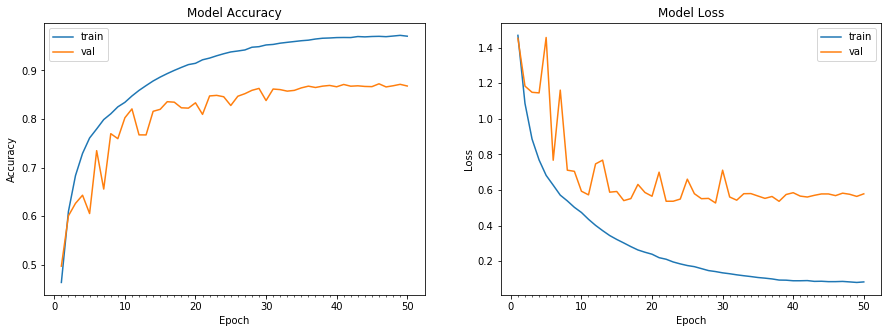

Accuracy on test data is: 10.40


In [39]:
from matplotlib import pyplot as plt
plot_model_history(model_info)
print ("Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model))

### Evaluate Model

In [53]:
# Test the model
model.load_weights('./Assignment16/maxAccuracy.hdf5')
score = model.evaluate(x_testTF, y_testTF, verbose=1, steps = VALIDATION_STEPS)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

79/78 [==============================] - 5s 60ms/step - loss: 0.5706 - acc: 0.8702
Test loss: 0.5769504623413086
Test accuracy: 0.87015426
